In [2]:
# Dashcam data from
# https://github.com/divamgupta/image-segmentation-keras
# CNN architcture and preprocessing code following code from Coursera's "Advanced Computer Vision with Tensorflow"

import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/fcnn-dataset.zip \
    -O /tmp/fcnn-dataset.zip

# extract the downloaded dataset to a local directory: /tmp/fcnn
local_zip = '/tmp/fcnn-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/fcnn')
zip_ref.close()
!ls /tmp/fcnn
!ls -l

--2021-02-24 01:29:24--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/fcnn-dataset.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.144, 172.217.12.240, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125577577 (120M) [application/zip]
Saving to: ‘/tmp/fcnn-dataset.zip’

/tmp/fcnn-dataset.z 100%[===================>] 119.76M   117MB/s    in 1.0s    

2021-02-24 01:29:25 (117 MB/s) - ‘/tmp/fcnn-dataset.zip’ saved [125577577/125577577]

dataset1
total 4
drwxr-xr-x 1 root root 4096 Feb 22 14:38 sample_data


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!  ls /tmp/fcnn/dataset1/images_prepped_train

In [4]:
# pixel labels in the video frames
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'byciclist', 'void']

(360, 480, 3)


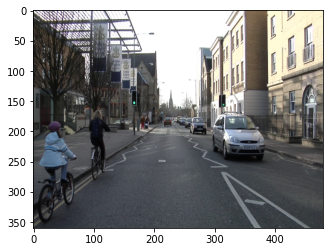

In [5]:
import matplotlib.pyplot as plt

direc = "/tmp/fcnn/dataset1/images_prepped_train/"
fileName = direc + "0016E5_01950.png"
img = plt.imread(fileName)
print(img.shape)
plt.imshow(img)


In [19]:
# preprocessing functions
def map_filename_to_image_and_mask(t_filename, a_filename, height=128, width=128):
  '''
  Preprocesses the dataset by:
    * resizing the input image and label maps
    * normalizing the input image pixels
    * reshaping the label maps from (height, width, 1) to (height, width, 12)

  Args:
    t_filename (string) -- path to the raw input image
    a_filename (string) -- path to the raw annotation (label map) file
    height (int) -- height in pixels to resize to
    width (int) -- width in pixels to resize to

  Returns:
    image (tensor) -- preprocessed image
    annotation (tensor) -- preprocessed annotation
  '''

  # Convert image and mask files to tensors 
  img_raw = tf.io.read_file(t_filename)
  anno_raw = tf.io.read_file(a_filename)
  image = tf.image.decode_jpeg(img_raw)
  #print(image.shape)
  annotation = tf.image.decode_jpeg(anno_raw)
 
  # Resize image and segmentation mask
  image = tf.image.resize(image, (height, width,))
  annotation = tf.image.resize(annotation, (height, width,))
  image = tf.reshape(image, (height, width, 3,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  annotation = tf.reshape(annotation, (height, width, 1,))
  stack_list = []

  # Reshape segmentation masks
  for c in range(len(class_names)):
    mask = tf.equal(annotation[:,:,0], tf.constant(c))
    stack_list.append(tf.cast(mask, dtype=tf.int32))
  
  annotation = tf.stack(stack_list, axis=2)

  # Normalize pixels in the input image
  image = image/127.5
  image -= 1

  return image, annotation

In [20]:

BATCH_SIZE = 64

def get_dataset_slice_paths(image_dir, label_map_dir):
  '''
  generates the lists of image and label map paths
  
  Args:
    image_dir (string) -- path to the input images directory
    label_map_dir (string) -- path to the label map directory

  Returns:
    image_paths (list of strings) -- paths to each image file
    label_map_paths (list of strings) -- paths to each label map
  '''
  image_file_list = os.listdir(image_dir)
  label_map_file_list = os.listdir(label_map_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
  label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

  return image_paths, label_map_paths


def get_training_dataset(image_paths, label_map_paths):
  '''
  Prepares shuffled batches of the training set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the train set
    label_map_paths (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(image_paths, label_map_paths):
  '''
  Prepares batches of the validation set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the val set
    label_map_paths (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()  

  return validation_dataset

In [21]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths('/tmp/fcnn/dataset1/images_prepped_train/','/tmp/fcnn/dataset1/annotations_prepped_train/')
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths('/tmp/fcnn/dataset1/images_prepped_test/','/tmp/fcnn/dataset1/annotations_prepped_test/')
print(len(training_image_paths),len(validation_image_paths))
# generate the train and val sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

367 101


In [9]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))

# print class name - normalized RGB tuple pairs
# the tuple values will be multiplied by 255 in the helper functions later
# to convert to the (0,0,0) to (255,255,255) RGB values you might be familiar with
for class_name, color in zip(class_names, colors):
  print(f'{class_name} -- {color}')

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


In [10]:
# Visualization Utilities

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste
  
  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(12):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps

  Args:
    image (numpy array) -- the input image
    labelmaps (list of arrays) -- contains the predicted and ground truth label maps
    titles (list of strings) -- display headings for the images to be displayed
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each vlass
  '''

  true_img = give_color_to_annotation(labelmaps[1])
  pred_img = give_color_to_annotation(labelmaps[0])

  image = image + 1
  image = image * 127.5
  images = np.uint8([image, pred_img, true_img])

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list) 

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[idx], fontsize=12)
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  image = image * 127.5
  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) - batch of images and annotations
  '''

  ds = dataset.unbatch()
  ds = ds.shuffle(buffer_size=100)

  plt.figure(figsize=(25, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  # we set the number of image-annotation pairs to 9
  # feel free to make this a function parameter if you want
  for idx, (image, annotation) in enumerate(ds.take(9)):
    plt.subplot(3, 3, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())

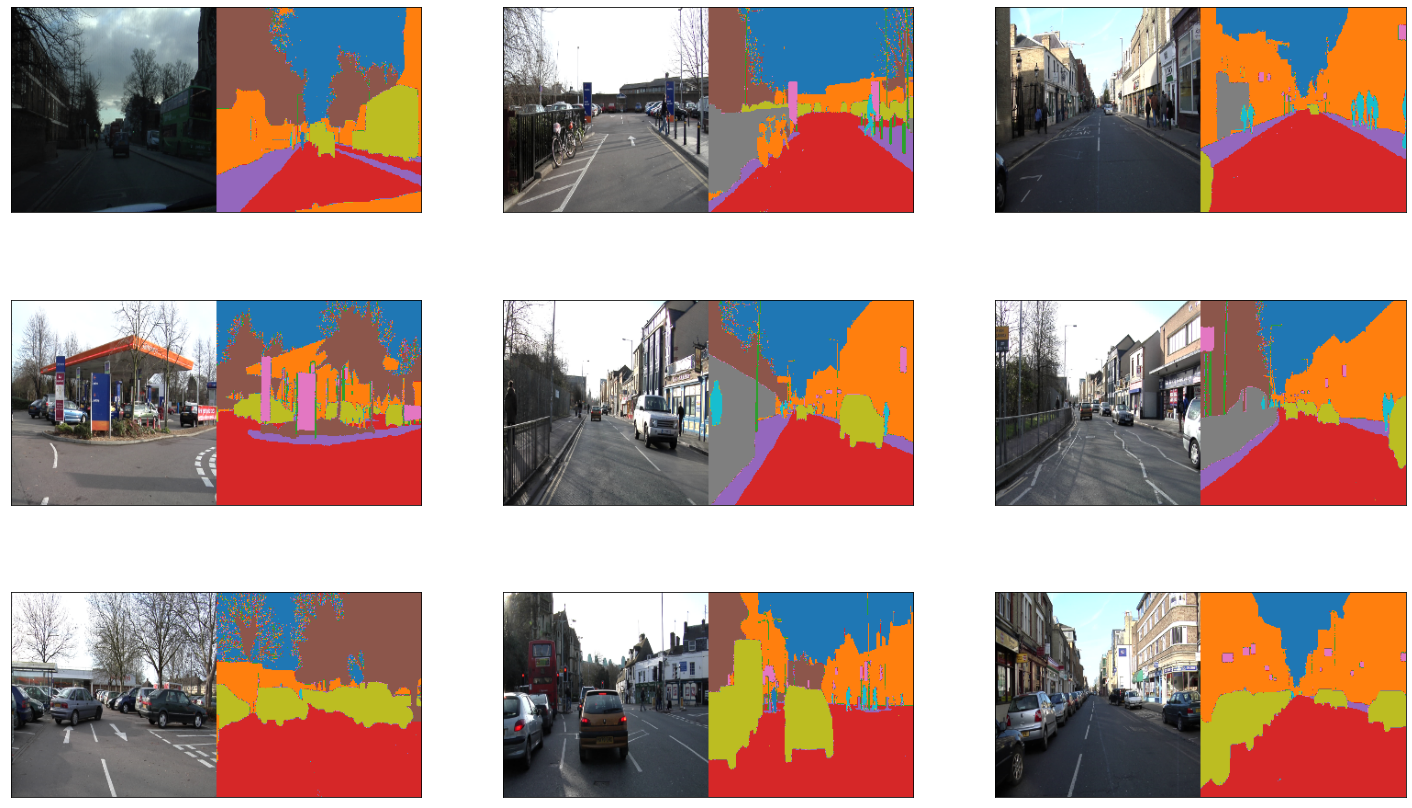

In [11]:
list_show_annotation(training_dataset)

In [12]:
# Test a UNet first

# Encoder Utilities

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

In [13]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

In [14]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

  Returns:
    c (tensor) -- output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks. 
  
  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''
  
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

In [22]:

def unet(imageShape,outputChannels):
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(imageShape, imageShape,3,))

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=outputChannels)
  
  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model
imageSize = 128
outputChannels = len(class_names)
# instantiate the model
model = unet(imageSize,outputChannels)

# see the resulting model architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 128, 128, 64) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 64) 36928       activation_36[0][0]              
____________________________________________________________________________________________

In [32]:
# configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
# configure the training parameters and train the model
# number of training images
train_count = 367

# number of validation images
validation_count = 101

EPOCHS = 180

steps_per_epoch = train_count//BATCH_SIZE
validation_steps = validation_count//BATCH_SIZE

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)



Epoch 1/180
5/5 [==============================] - 8s 1s/step - loss: 1.5437 - accuracy: 0.7406 - val_loss: 1.2467 - val_accuracy: 0.5829
Epoch 2/180
5/5 [==============================] - 6s 1s/step - loss: 0.9498 - accuracy: 0.6990 - val_loss: 0.9190 - val_accuracy: 0.6399
Epoch 3/180
5/5 [==============================] - 5s 1s/step - loss: 0.8146 - accuracy: 0.7418 - val_loss: 0.9111 - val_accuracy: 0.7097
Epoch 4/180
5/5 [==============================] - 5s 1s/step - loss: 0.7916 - accuracy: 0.7604 - val_loss: 0.8484 - val_accuracy: 0.7269
Epoch 5/180
5/5 [==============================] - 5s 1s/step - loss: 0.7223 - accuracy: 0.7743 - val_loss: 0.7455 - val_accuracy: 0.7901
Epoch 6/180
5/5 [==============================] - 5s 1s/step - loss: 0.6856 - accuracy: 0.7915 - val_loss: 0.7321 - val_accuracy: 0.8025
Epoch 7/180
5/5 [==============================] - 5s 1s/step - loss: 0.6508 - accuracy: 0.8020 - val_loss: 0.7096 - val_accuracy: 0.8048
Epoch 8/180
5/5 [=================

In [25]:
def get_images_and_segments_test_arrays():
  '''
  Gets a subsample of the val set as your test set

  Returns:
    Test set containing ground truth images and label maps
  '''
  y_true_segments = []
  y_true_images = []
  test_count = 64

  ds = validation_dataset.unbatch()
  ds = ds.batch(101)

  for image, annotation in ds.take(1):
    y_true_images = image
    y_true_segments = annotation


  y_true_segments = y_true_segments[:test_count, : ,: , :]
  y_true_segments = np.argmax(y_true_segments, axis=3)  

  return y_true_images, y_true_segments

# load the ground truth images and segmentation masks
y_true_images, y_true_segments = get_images_and_segments_test_arrays()

In [34]:
# get the model prediction
results = model.predict(validation_dataset, steps=validation_steps)

# for each pixel, get the slice number which has the highest probability
results = np.argmax(results, axis=3)

In [35]:
def compute_metrics(y_true, y_pred):
  '''
  Computes IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label map
    y_pred (tensor) - predicted label map
  '''
  
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001

  for i in range(12):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

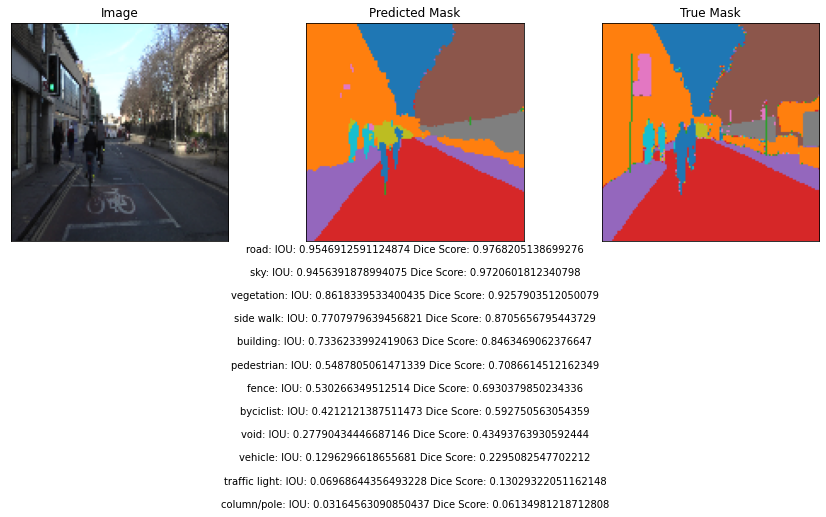

In [36]:
# input a number from 0 to 63 to pick an image from the test set
integer_slider = 0

# compute metrics
iou, dice_score = compute_metrics(y_true_segments[integer_slider], results[integer_slider])  

# visualize the output and metrics
show_predictions(y_true_images[integer_slider], [results[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou, dice_score)

In [37]:
# compute class-wise metrics
cls_wise_iou, cls_wise_dice_score = compute_metrics(y_true_segments, results)


In [38]:
# print IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou)) 

sky            0.938526830534968 
building       0.7786095770150909 
column/pole    0.06221225467806368 
road           0.9453580448546566 
side walk      0.7745462618846509 
vegetation     0.8675467812671367 
traffic light  0.047547623333172626 
fence          0.5240820604723545 
vehicle        0.37919167890209277 
pedestrian     0.20863620064149968 
byciclist      0.27530920781438833 
void           0.18261279588618423 


In [39]:
# print the dice score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 

sky            0.968288718835102 
building       0.8755261268041691 
column/pole    0.11713714367955419 
road           0.9719116204551098 
side walk      0.8729513324746159 
vegetation     0.9290763583474007 
traffic light  0.09077892462000363 
fence          0.6877347016068474 
vehicle        0.549875241815681 
pedestrian     0.3452423494431093 
byciclist      0.4317528740753158 
void           0.30882939298039397 
